**Predicting electric motor temperature / insurance charges with a regression model using Gradient Descent**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sb
import os
dataset = 'measures_v2' #'insurance'
data = pd.read_csv(os.getcwd()+'/datasets/'+dataset+'.csv')

In [2]:
data

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274497,0.791801,41.934347,0.000380,-2.000169,1.097528,62.147780,38.653720,23.989078,-8.116730e-60,71
1330812,-2.258684,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142646,38.656328,23.970700,-5.815891e-60,71
1330813,-2.130312,30.721312,45.211576,0.804914,41.804819,0.002301,-1.999268,1.098765,62.138387,38.650923,23.977234,-4.167268e-60,71
1330814,-2.268498,30.721316,45.193508,0.763091,41.762220,0.005662,-2.000999,1.095696,62.133422,38.655686,24.001421,-2.985978e-60,71


In [3]:
# for insurance.csv
if dataset == 'insurance':
# one hot encoding and concatenating
    s = pd.Series(data['sex'])
    one_hot_encoded = pd.get_dummies(s)

    ohe_df = pd.DataFrame(one_hot_encoded)

    preprocessed_data = pd.concat([data['age'], ohe_df], axis=1)

    preprocessed_data = pd.concat([preprocessed_data, data['bmi']], axis=1)

    preprocessed_data = pd.concat([preprocessed_data, data['children']], axis=1)

    s = pd.Series(data['smoker'])
    one_hot_encoded = pd.get_dummies(s)

    ohe_df = pd.DataFrame(one_hot_encoded)

    preprocessed_data = pd.concat([preprocessed_data, ohe_df], axis=1)

    s = pd.Series(data['region'])
    one_hot_encoded = pd.get_dummies(s)

    ohe_df = pd.DataFrame(one_hot_encoded)

    preprocessed_data = pd.concat([preprocessed_data, ohe_df], axis=1)

    preprocessed_data = pd.concat([preprocessed_data, data['charges']], axis=1)
    data = preprocessed_data


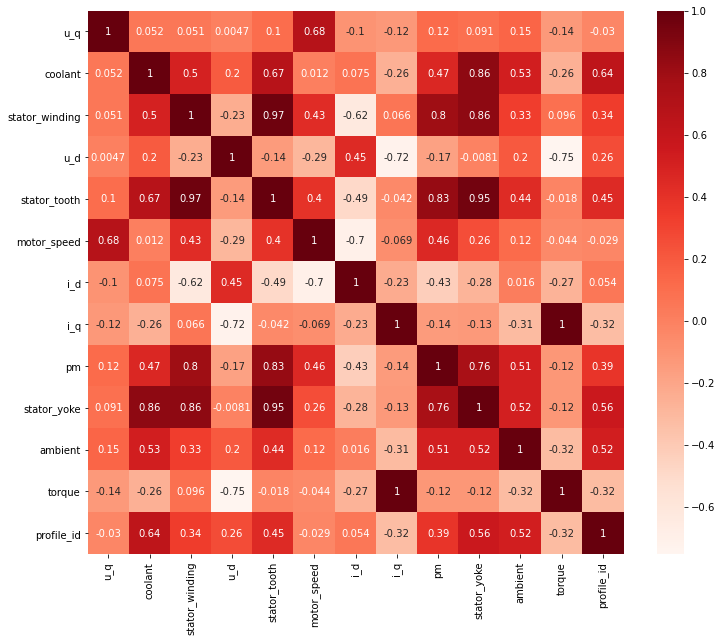

In [4]:
plt.figure(figsize=(12,10))
cor = data.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
target = "stator_tooth" #stator_yoke, pm, stator_tooth, stator_winding, coolant
#Correlation with output variable
cor_target = abs(cor[target]) # cor[target]
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.30]
relevant_features

coolant           0.674974
stator_winding    0.970135
stator_tooth      1.000000
motor_speed       0.398431
i_d               0.487062
pm                0.832084
stator_yoke       0.953115
ambient           0.443470
profile_id        0.450821
Name: stator_tooth, dtype: float64

In [6]:
np.array(relevant_features.keys())

array(['coolant', 'stator_winding', 'stator_tooth', 'motor_speed', 'i_d',
       'pm', 'stator_yoke', 'ambient', 'profile_id'], dtype=object)

In [7]:
features = np.array(relevant_features.keys())
data = data[features]
data

,coolant,stator_winding,stator_tooth,motor_speed,i_d,pm,stator_yoke,ambient,profile_id
0,18.805172,19.086670,18.293219,0.002866,0.004419,24.554214,18.316547,19.850691,17
1,18.818571,19.092390,18.294807,0.000257,0.000606,24.538078,18.314955,19.850672,17
2,18.828770,19.089380,18.294094,0.002355,0.001290,24.544693,18.326307,19.850657,17
3,18.835567,19.083031,18.292542,0.006105,0.000026,24.554018,18.330833,19.850647,17
4,18.857033,19.082525,18.291428,0.003133,-0.064317,24.565397,18.326662,19.850639,17
...,...,...,...,...,...,...,...,...,...
1330811,30.721298,45.274497,41.934347,0.000380,-2.000169,62.147780,38.653720,23.989078,71
1330812,30.721306,45.239017,41.868923,0.002985,-2.000499,62.142646,38.656328,23.970700,71
1330813,30.721312,45.211576,41.804819,0.002301,-1.999268,62.138387,38.650923,23.977234,71
1330814,30.721316,45.193508,41.762220,0.005662,-2.000999,62.133422,38.655686,24.001421,71


In [8]:
# split data into input and output variables
y = data[target]
X = data.drop(target, axis=1)

In [9]:
target_mu = np.mean(data[target])
target_std = np.std(data[target])

In [10]:
def featureNormalization(data):
    mu  = np.mean(data)
    std = np.std(data)
    return (data - mu) / (std)

In [11]:
X_norm = featureNormalization(X)
y_norm = featureNormalization(y)

In [12]:
#split into train and test data
X_train_data = X_norm[0:int(len(X_norm)*0.8)]
X_test_data  = X_norm[int(len(X_norm)*0.8)::]

In [13]:
#split into train and test data
Y_train_data = np.array(y_norm[0:int(len(y_norm)*0.8)])
Y_test_data  = np.array(y_norm[int(len(y_norm)*0.8)::])

In [14]:
m = len(X_train_data)

In [15]:
#  Add intercept term to data
X_train_data = np.append(np.ones([m, 1], dtype=np.int32), X_train_data, axis=1)

In [16]:
def computeCostMulti(X, y, theta):
    m = len(y)
    theta = np.array(theta)
    J = (1/(2*m))*((np.square(( X @ theta - y))).sum())
    return J

In [17]:
def gradientDescentMulti(X, y, theta, alpha, iterations):
    J_history = np.zeros(iterations)
    m = len(y)
    for i in range(iterations):
        theta = np.subtract(theta, alpha * (1/m) * (( (X @ theta) - y ).transpose() @ X).transpose())
        J_history[i] = computeCostMulti(X, y, theta);
    return theta, J_history

In [18]:
theta = np.zeros((len(X_train_data.transpose()), 1));
alpha     =  0.01
num_iters =  250; 

In [19]:
Y_train_data = np.expand_dims(Y_train_data, axis=1)

In [20]:
[theta, J_history] = gradientDescentMulti(X_train_data, Y_train_data, theta, alpha, num_iters);

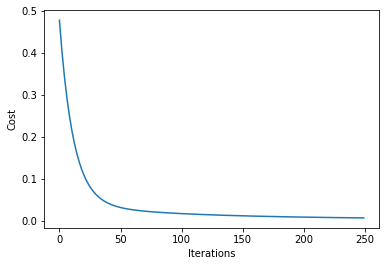

In [21]:
x = np.arange(len(J_history))
plt.plot(x, J_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [22]:
X_test_data = np.append(np.ones([len(X_test_data), 1], dtype=np.int32), X_test_data, axis=1)

In [23]:
y_test_out = X_test_data @ theta 

In [24]:
y_test_out = np.array(y_test_out)
Y_test_data = np.array(Y_test_data)

In [25]:
r2_score(Y_test_data, y_test_out.ravel())

0.9718618938450825

In [26]:
mean_squared_error(Y_test_data, y_test_out.ravel())

0.019530927085455296

In [27]:
observation_pair_list = []
for i in range(len(Y_test_data)):
    observation_pair_list.append([Y_test_data[i], y_test_out.ravel()[i]])

In [28]:
observation_pair_list.sort()

In [61]:
y_true = np.array(list(zip(*observation_pair_list))[0])*target_std+target_mu

In [62]:
y_pred = np.array(list(zip(*observation_pair_list))[1])*target_std+target_mu

In [63]:
split = 1
limit = int(len(y_true)*split)

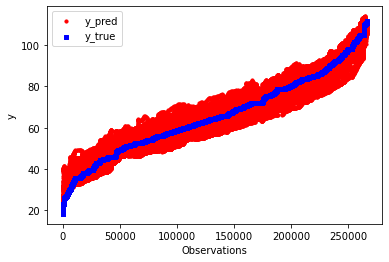

In [64]:
Y_plot = y_true[0:limit] 
y_out  = y_pred[0:limit]
fig = plt.figure()
ax1 = fig.add_subplot(111)
x = np.arange(len(Y_plot))
ax1.scatter(x, y_out, s=10, c='r', marker="o", label='y_pred')
ax1.scatter(x, Y_plot, s=10, c='b', marker="s", label='y_true')
plt.legend(loc='upper left');
plt.xlabel('Observations')
plt.ylabel('y')
plt.show()

In [74]:
# for density of points
points = 0
tol = 0.1
for i in range(len(y_out)):
    if Y_plot[i]*(1-tol) <= y_out[i] and y_out[i] <= Y_plot[i]*(1+tol):
        points+=1
points

245490

In [33]:
############################################### SKLEARN MODELS ###################################################

In [34]:
Y_test_data = np.array(Y_test_data).ravel()
Y_train_data = np.array(Y_train_data).ravel()

In [55]:
from sklearn.linear_model import SGDRegressor
reg = SGDRegressor(max_iter=250, tol=1e-3, alpha=0.01)
reg.fit(X_train_data, Y_train_data)
reg.score(X_test_data, Y_test_data)

0.9970158153105947

In [36]:
mean_squared_error(Y_test_data, reg.predict(X_test_data))

0.0020377495018401117

In [37]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_data, Y_train_data)
reg.score(X_test_data, Y_test_data)

0.99811348413674

In [38]:
mean_squared_error(Y_test_data, reg.predict(X_test_data))

0.0013094486021209442

In [39]:
############################################### SKLEARN MODELS ###################################################